# **NOTE**
# Val_accuracy has a maximum of 75% 
(changing network architecture won't work);<br>
Because (after data investigation) I found that many samples are misclassifed & some samples are corrupted (face recognition & preprocessing issues)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from PIL import ImageFile
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('INFO')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [2]:
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    horizontal_flip = True,
                                    brightness_range=(0.8,1.2)
                                    )

test_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    brightness_range=(0.8,1.2),
                                    horizontal_flip = True,
                                    )


training_set = train_datagen.flow_from_directory(
                                                 '../input/faceshape-processed/dataset/train',
                                                 target_size = (250,190),
                                                 batch_size = 64,
                                                 color_mode = 'grayscale',
                                                 shuffle = True,
                                                 class_mode = 'categorical'
                                                 )

test_set = test_datagen.flow_from_directory(
                                            '../input/faceshape-processed/dataset/test',
                                            target_size = (250,190),
                                            batch_size = 64,
                                            color_mode = 'grayscale',
                                            shuffle=True,
                                            class_mode = 'categorical'
                                            )

Found 3981 images belonging to 5 classes.
Found 998 images belonging to 5 classes.


In [3]:
# Build model

model = Sequential()
model.add(Conv2D(8, (7, 7), activation='selu', padding="valid", input_shape=(250,190,1)))
model.add(Conv2D(8, (5, 5), activation='selu', padding="valid"))
model.add(MaxPooling2D(pool_size=(5,5),padding="valid", strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(3,3),padding="valid", strides=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='selu'))
model.add(Dense(5, activation="softmax"))

model.summary()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 244, 184, 8)       400       
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 180, 8)       1608      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 118, 88, 8)       0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 43, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 19952)             0         
                                                                 
 dense (Dense)               (None, 1024)              2

In [4]:
X_train, y_train = next(training_set)
X_test, y_test = next(test_set)

1/1 [==============================] - 0s 166ms/step


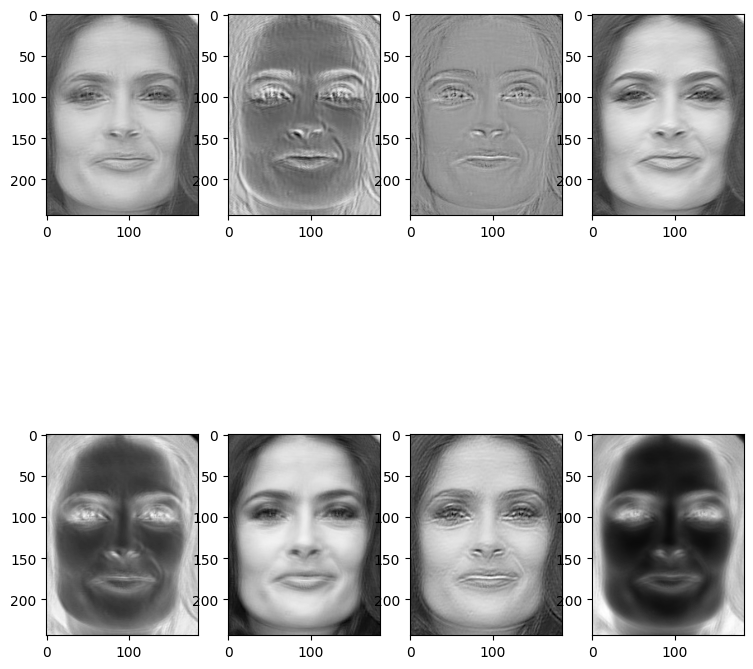

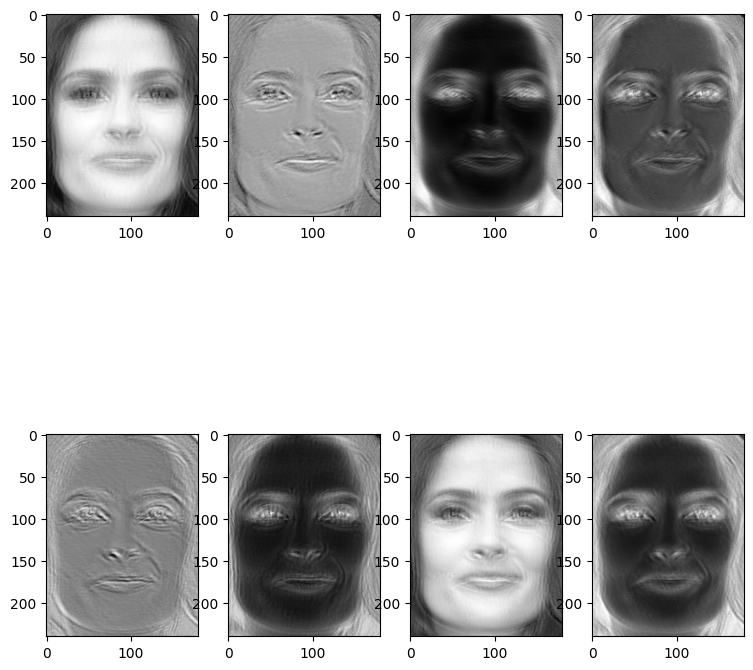

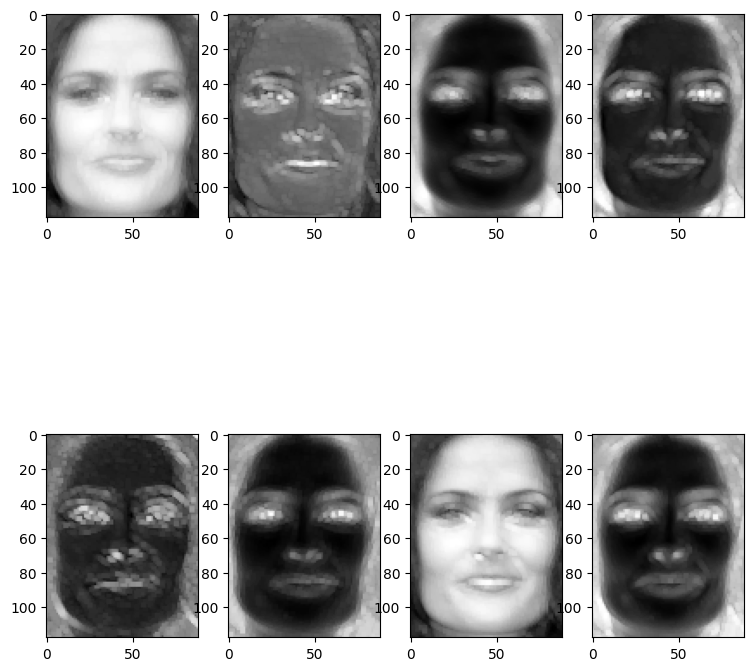

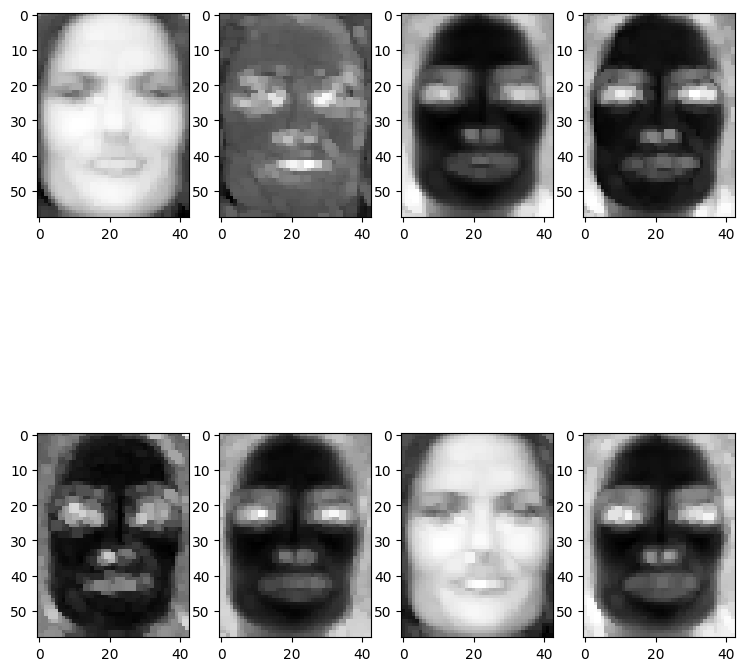

In [5]:
# Visualize convolution processing
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[0].reshape(1,250,190,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*4.5,col_size*2.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
col_size = 4
row_size = 2
n_layers = 4
for layer_index in range(n_layers):#(len(model.layers)-10):
    display_activation(activations, col_size, row_size, layer_index)

In [6]:
# Custom early stop
class ValAccEarlyStop(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ValAccEarlyStop, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [ ]:
# Training phase
history = model.fit(
                             training_set,
                             epochs = 50,
                             validation_data = test_set,
                             shuffle = True,
                            callbacks=[
                                 ValAccEarlyStop(0.73)
                             ]
                            )

Epoch 1/50
63/63 [==============================] - 101s 2s/step - loss: 8.7292 - accuracy: 0.2298 - val_loss: 1.5707 - val_accuracy: 0.2365
Epoch 2/50
63/63 [==============================] - 99s 2s/step - loss: 1.5895 - accuracy: 0.2972 - val_loss: 1.6635 - val_accuracy: 0.3236
Epoch 3/50
63/63 [==============================] - 99s 2s/step - loss: 1.5026 - accuracy: 0.3419 - val_loss: 1.4125 - val_accuracy: 0.4058
Epoch 4/50
63/63 [==============================] - 97s 2s/step - loss: 1.4401 - accuracy: 0.3848 - val_loss: 1.4025 - val_accuracy: 0.4058
Epoch 5/50
63/63 [==============================] - 93s 1s/step - loss: 1.3883 - accuracy: 0.4213 - val_loss: 1.3157 - val_accuracy: 0.4409
Epoch 6/50
63/63 [==============================] - 95s 2s/step - loss: 1.3085 - accuracy: 0.4474 - val_loss: 1.3410 - val_accuracy: 0.4709
Epoch 7/50
63/63 [==============================] - 94s 1s/step - loss: 1.2441 - accuracy: 0.4848 - val_loss: 1.2541 - val_accuracy: 0.4820
Epoch 8/50
63/63 [=

In [18]:
# Evaluate Model
scoreSeg = model.evaluate_generator(test_set)
print("Accuracy = ",scoreSeg[1])

Accuracy =  0.7304609417915344


In [19]:
model.save("face-shape-recognizer.h5")

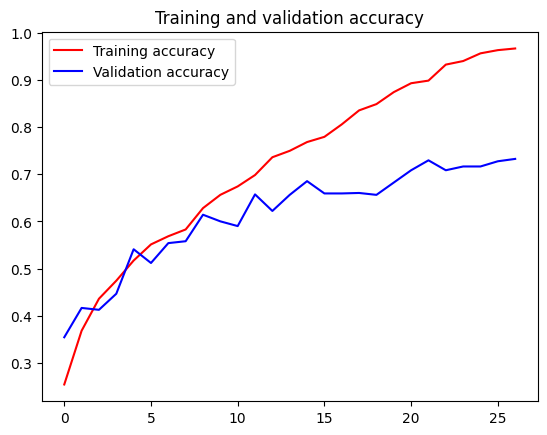

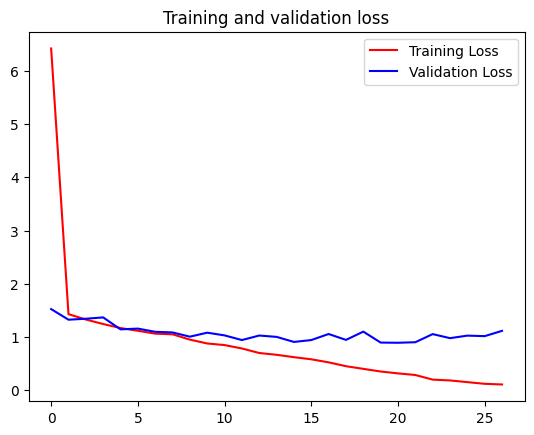

In [22]:
# Visualize Loss & Accuracy

%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

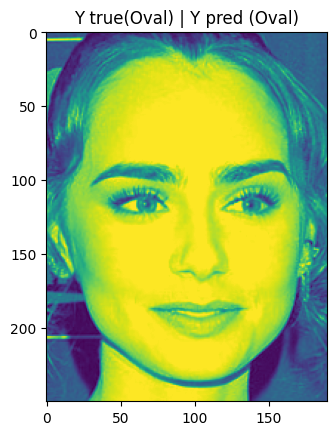

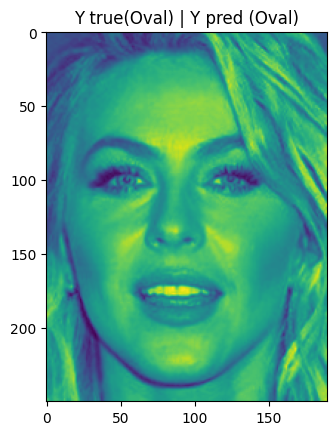

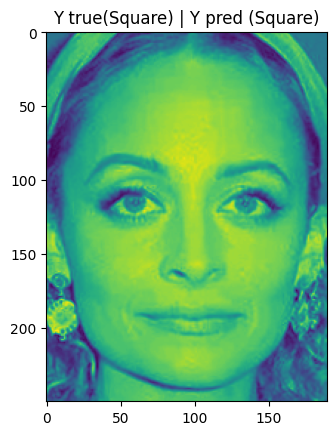

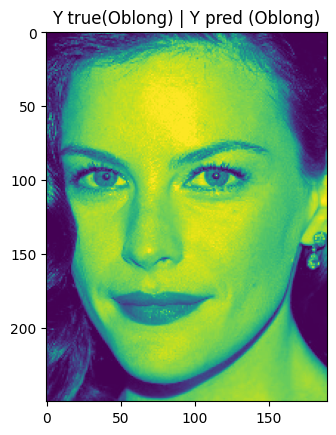

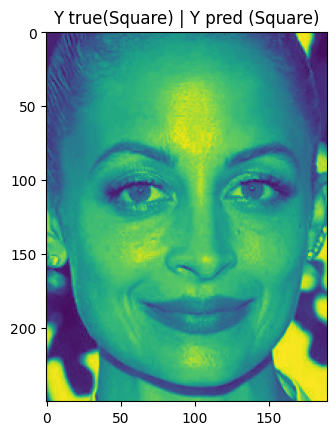

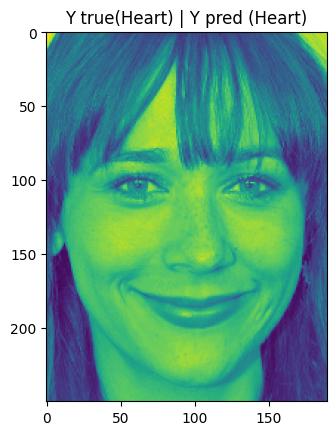

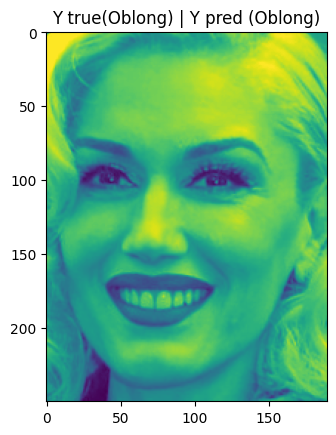

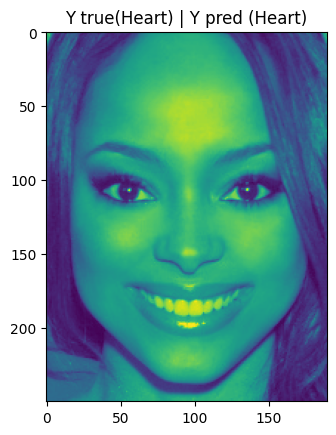

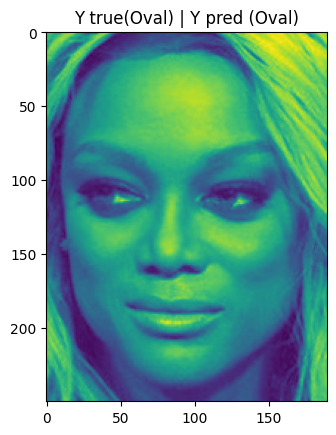

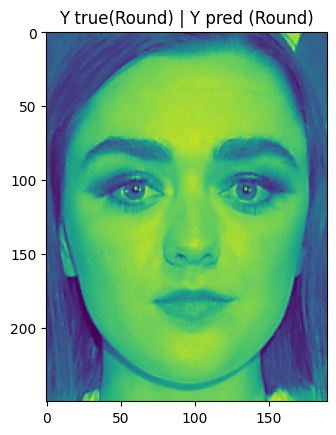

In [23]:
# Make some predictions on training data

from tensorflow.keras.preprocessing import image

labels = list(training_set.class_indices)

for i in np.random.randint(X_train.shape[0], size=10):
    img = image.img_to_array(X_train[i])
    img = np.expand_dims(img, axis=0)
    images = np.vstack([img])
    y_pred = np.argmax(model.predict(img,verbose=0), axis=1)[0]
    y_true = np.argmax(y_train[i])
    plt.imshow(X_train[i])
    plt.title(f"Y true({labels[y_true]}) | Y pred ({labels[y_pred]})")
    plt.show()

In [24]:
# save the model weights
model.save_weights("model_weights.h5")

In [25]:
# save the model architecture as JSON
with open('model.json', 'w') as f:
    f.write(model.to_json())